# 1. Load Library

In [1]:
from datetime import datetime
import io
import pandas as pd
import pyreadstat
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency,zscore,ttest_1samp,ttest_ind,levene,kstest,mannwhitneyu,ttest_rel,norm,rankdata,kruskal,pearsonr,spearmanr
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd,MultiComparison
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import xlsxwriter
from openpyxl.drawing.image import Image

# 2. Load Scope Spreadsheets

In [2]:
scopes = ['https://www.googleapis.com/auth/spreadsheets',
        'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('/Users/tanhpuh/Documents/GitHub/codev2/code/Python/Pandas Google Spreadsheets/service_account.json', scopes=scopes)

gc = gspread.authorize(credentials)

gauth = GoogleAuth()
drive = GoogleDrive(gauth)
# share service account email to sheet: pandas-google-spreadsheets@thermal-creek-396612.iam.gserviceaccount.com

# 3. Read Data SPSS

In [3]:
# File path to your .sav file
file_path = "/Users/tanhpuh/Documents/GitHub/codev2/code/Python/lean/Data SPSS/Data thuc hanh.csv"

# Read the SPSS file
df = pd.read_csv(file_path)
# df, meta = pyreadstat.read_sav(file_path)

# Display the first few rows and column information
df.head(),df.info(),df.describe()

# Capture the output of df.info()
buffer_info = io.StringIO()
df.info(buf=buffer_info)
info_str = buffer_info.getvalue()

# Capture the output of df.describe()
describe_df = df.describe()

# Save to Excel
with pd.ExcelWriter('info_describe.xlsx') as writer:
  # Write df.info() to the first sheet
  pd.DataFrame({'Info': info_str.split('\n')}).to_excel(writer, sheet_name='Info', index=False)
  
  # Write df.describe() to the second sheet
  describe_df.to_excel(writer, sheet_name='Describe')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 153 entries, stt to hocvan4n
dtypes: float64(1), int64(44), object(108)
memory usage: 597.8+ KB


# 4. Regression Analysis

# 4.1 Simple linear regression

**Input Data**

In [4]:
# File path to your .sav file
file_path = "/Users/tanhpuh/Documents/GitHub/codev2/code/Python/lean/Data SPSS/Tqvahq.csv"

# Read the SPSS file
dscp = pd.read_csv(file_path)

**Input Test Value**

In [5]:
# Input Data
table = dscp
x = table['chaohang']
y = table['doanhso']
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

# 4.1.1 Correlation Coefficient
Đo lường mỗi quan hệ giữa 2 hoặc nhiều biến định lượng.

Đo lường mối quan hệ giữa 2 biến doanh số bán hàng (y) và chi phí chào hàng (x). Công ty ghi nhận 12 khu vực trong năm 1996

**Scatter Plot**

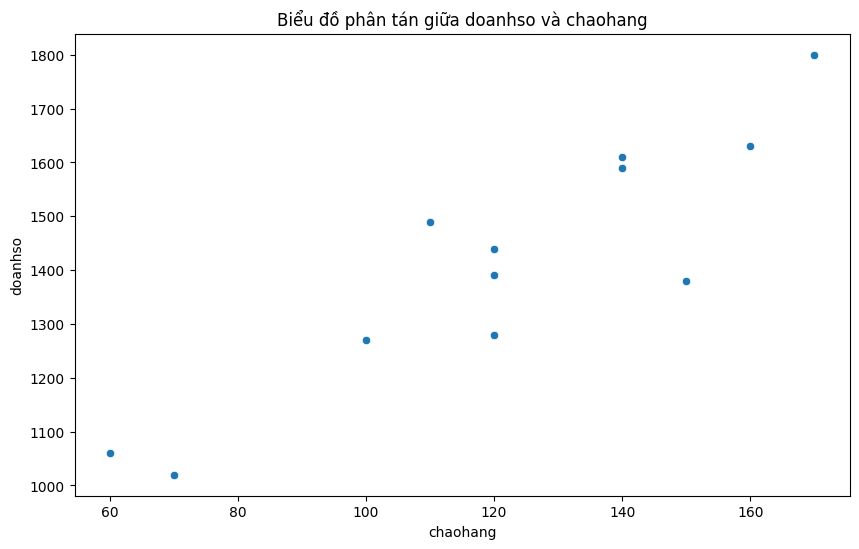

In [6]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=table, x=f'{x.name}', y=f'{y.name}')

# Add labels and title
plt.xlabel(f'{x.name}')
plt.ylabel(f'{y.name}')
plt.title(f'Biểu đồ phân tán giữa {y.name} và {x.name}')

# Save the plot as an image file
plt.savefig(f'scatterplot {y.name} and {x.name}.png')

# Show the plot
plt.show()

**Kolmogorov-Smirnow test to see if the data is normally distributed:**
- If the data is normal distribution, use Pearson Correlation.
- If the data is not normal distribution, use Spearman Correlation.

In [7]:
# Perform the Kolmogorov-Smirnov test for normality on 'x' and 'y'
ks_statistic_x, p_value_x = kstest(x, 'norm', args=(x.mean(), x.std()))
ks_statistic_y, p_value_y = kstest(y, 'norm', args=(y.mean(), y.std()))

# Create the Kolmogorov-Smirnov test results table for 'x'
ks_test_results_x = pd.DataFrame({
  'Variable': ['x'],
  'KS Statistic': [ks_statistic_x],
  'p-value': [p_value_x],
  'alpha': [alpha],
  'Result': ['Reject the null hypothesis (data does not follow normal distribution)' if p_value_x <= alpha else 'Fail to reject the null hypothesis (data follows normal distribution)']
})

# Create the Kolmogorov-Smirnov test results table for 'y'
ks_test_results_y = pd.DataFrame({
  'Variable': ['y'],
  'KS Statistic': [ks_statistic_y],
  'p-value': [p_value_y],
  'alpha': [alpha],
  'Result': ['Reject the null hypothesis (data does not follow normal distribution)' if p_value_y <= alpha else 'Fail to reject the null hypothesis (data follows normal distribution)']
})

# Results for Test
if p_value_x > alpha and p_value_y > alpha:
  result_ks = 'Data follow normal distribution. Chose Pearson Correlation'
  conclusion_ks = pd.DataFrame({
    'Result': [result_ks]
  })
else:
  result_ks = 'Data does not follow normal distribution. Chose Spearman Correlation'
  conclusion_ks = pd.DataFrame({
    'Result': [result_ks]
  })

print('Kolmogorov-Smirnov Test Results for x:')
print(ks_test_results_x)

print('Kolmogorov-Smirnov Test Results for y:')
print(ks_test_results_y)

print('Conclusion:')
print(conclusion_ks)

# Lưu kết quả vào file Excel
with pd.ExcelWriter('simple_linear_regression_ks_test_results.xlsx') as writer:
  ks_test_results_x.to_excel(writer, sheet_name=f'KS Test Results {x.name}', index=False)
  ks_test_results_y.to_excel(writer, sheet_name=f'KS Test Results {y.name}', index=False)
  conclusion_ks.to_excel(writer, sheet_name='Conclusion', index=False)

print('Read file simple_linear_regression_ks_test_results.xlsx')

Kolmogorov-Smirnov Test Results for x:
  Variable  KS Statistic   p-value  alpha  \
0        x      0.146845  0.925214   0.05   

                                              Result  
0  Fail to reject the null hypothesis (data follo...  
Kolmogorov-Smirnov Test Results for y:
  Variable  KS Statistic   p-value  alpha  \
0        y      0.110075  0.995062   0.05   

                                              Result  
0  Fail to reject the null hypothesis (data follo...  
Conclusion:
                                              Result
0  Data follow normal distribution. Chose Pearson...
Read file simple_linear_regression_ks_test_results.xlsx


**Calculator r (Correlation Coefficient)**
* Pearson - dữ liệu có phân phối chuẩn. 
* Spearman - dữ liện không cần phân phối chuẩn.

In [8]:
# Tính hệ số tương quan Pearson
pearson_corr, pearson_p_value = pearsonr(x, y)

# Tạo bảng tương quan Pearson
pearson_corr_df = pd.DataFrame({
  'Variable 1': ['chaohang'],
  'Variable 2': ['doanhso'],
  'Pearson Correlation': [pearson_corr],
  'p-value': [pearson_p_value]
})
print('Pearson Correlation:')
print(pearson_corr_df)

# Conclusion based on Pearson correlation coefficient
if abs(pearson_corr) >= 0.7:
  correlation_strength = "strong"
elif 0.3 <= abs(pearson_corr) < 0.7:
  correlation_strength = "moderate"
else:
  correlation_strength = "weak"

if pearson_p_value < alpha:
  significance = "significant"
else:
  significance = "not significant"

conclusion_pearson = f"r Pearson: The correlation between {x.name} and {y.name} is {correlation_strength} and {significance}."

print(conclusion_pearson)

# Tính hệ số tương quan Spearman
spearman_corr, spearman_p_value = spearmanr(x, y)

# Tạo bảng tương quan Spearman
spearman_corr_df = pd.DataFrame({
  'Variable 1': ['chaohang'],
  'Variable 2': ['doanhso'],
  'Spearman Correlation': [spearman_corr],
  'p-value': [spearman_p_value]
})
print('Spearman Correlation:')
print(spearman_corr_df)

# Conclusion based on Spearman correlation coefficient
if abs(spearman_corr) >= 0.7:
  correlation_strength_spearman = "strong"
elif 0.3 <= abs(spearman_corr) < 0.7:
  correlation_strength_spearman = "moderate"
else:
  correlation_strength_spearman = "weak"

if spearman_p_value < alpha:
  significance_spearman = "significant"
else:
  significance_spearman = "not significant"

conclusion_spearman = f"r Spearman: The correlation between {x.name} and {y.name} is {correlation_strength_spearman} and {significance_spearman}."

print(conclusion_spearman)

conclusion = pd.DataFrame({
  'Result Pearson Correlation': [conclusion_pearson],
  'Result Spearman Correlation': [conclusion_spearman],
  'Chose Test Type':[result_ks]
})

print(result_ks)

# Lưu kết quả vào file Excel
with pd.ExcelWriter('simple_linear_regression_correlation_coefficient_results.xlsx') as writer:
  pearson_corr_df.to_excel(writer, sheet_name='Pearson Correlation', index=False)
  spearman_corr_df.to_excel(writer, sheet_name='Spearman Correlation', index=False)
  conclusion.to_excel(writer, sheet_name='Conclusion', index=False)

  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Bar Plot')
  
  # Insert the image into the worksheet
  worksheet.insert_image('A1', f'scatterplot {y.name} and {x.name}.png')
  
print('Read file simple_linear_regression_correlation_coefficient_results.xlsx')

Pearson Correlation:
  Variable 1 Variable 2  Pearson Correlation   p-value
0   chaohang    doanhso             0.904627  0.000053
r Pearson: The correlation between chaohang and doanhso is strong and significant.
Spearman Correlation:
  Variable 1 Variable 2  Spearman Correlation   p-value
0   chaohang    doanhso              0.821901  0.001038
r Spearman: The correlation between chaohang and doanhso is strong and significant.
Data follow normal distribution. Chose Pearson Correlation
Read file simple_linear_regression_correlation_coefficient_results.xlsx


# 4.1.2 Simple linear regression

**Simple linear regression**

                            OLS Regression Results                            
Dep. Variable:                doanhso   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     45.05
Date:                Mon, 30 Dec 2024   Prob (F-statistic):           5.29e-05
Time:                        16:12:21   Log-Likelihood:                -71.636
No. Observations:                  12   AIC:                             147.3
Df Residuals:                      10   BIC:                             148.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    651.5229    117.384      5.550      0.0

/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 

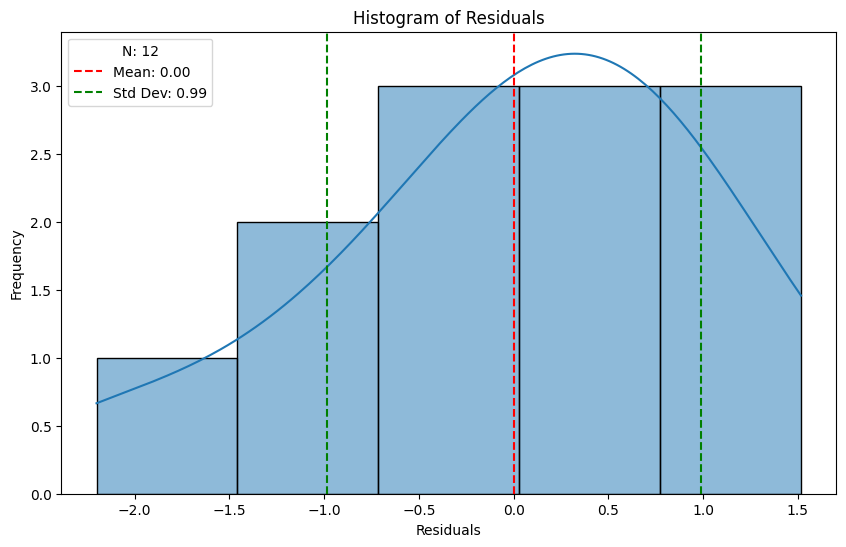

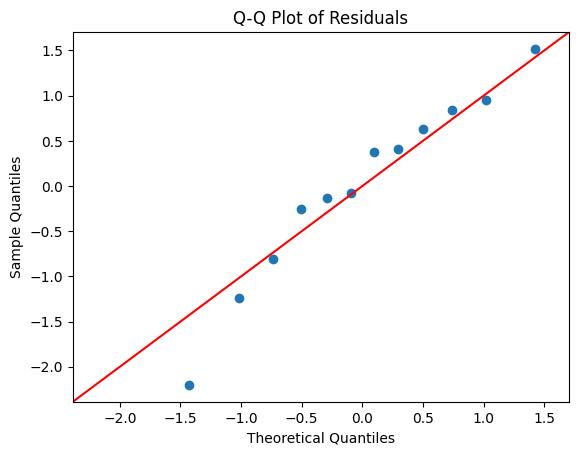

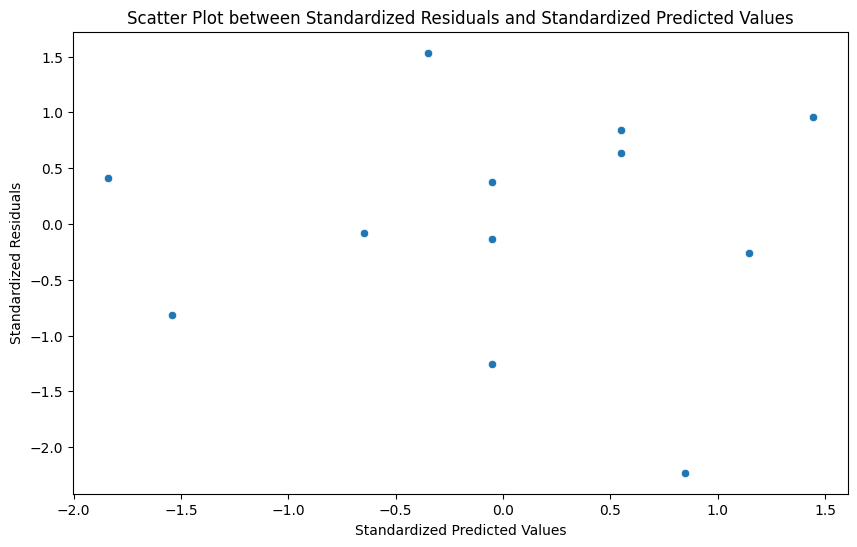

Read file simple_linear_regression_results.xlsx


In [9]:
# Tạo mô hình hồi quy tuyến tính sử dụng công thức
model = smf.ols(f'{y.name} ~ {x.name}', data=table).fit()
print(model.summary())

# Kiểm định Durbin-Watson
residuals = model.resid
residuals_test = abs(residuals)
durbin_watson = sm.stats.stattools.durbin_watson(residuals)

standardized_residuals = model.get_influence().resid_studentized_internal

# Redesign the model_summary table
model_summary = pd.DataFrame({
  'Date': [model.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model.rsquared],
  'Adj. R-squared': [model.rsquared_adj],
  'Durbin Watson': [durbin_watson]
})

# Bảng ANOVA
anova_table = sm.stats.anova_lm(model, typ=2, robust='hc3')
# Calculate the total sum of squares (SST)
anova_table = sm.stats.anova_lm(model, typ=2, robust='hc3')
# Calculate the total sum of squares (SST)
sst = sum((y - y.mean()) ** 2)
# Calculate the residual sum of squares (SSE)
sse = sum(residuals ** 2)
# Calculate the regression sum of squares (SSR)
ssr_regression = sst - sse
# Calculate total sum of squares
ssr_residual = anova_table['sum_sq']['Residual']
# Calculate reression sum of squares
ssr_total = ssr_regression + ssr_residual
# Degrees of freedom
df_residual = model.summary().tables[0][6][1].data
df_regression = model.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model.summary().tables[0][2][3].data, errors='coerce')
anova_p_value = pd.to_numeric(model.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [ssr_regression, ssr_residual, ssr_total],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [anova_p_value, None, None]
})
print(anova_table)

# Bảng Coefficients
coefficients = model.summary2().tables[1]

# Bảng Correlations - Kiểm định Spearman cho 2 biến x và abs(residuals) (kiểm định giả định phương sai của sai số không đổi)
spearman_corr, spearman_p_value = spearmanr(x, residuals_test)

# Conclusion based on Spearman correlation coefficient
if abs(spearman_corr) >= 0.7:
  correlation_strength_spearman = "strong"
elif 0.3 <= abs(spearman_corr) < 0.7:
  correlation_strength_spearman = "moderate"
else:
  correlation_strength_spearman = "weak"

if spearman_p_value < alpha:
  significance_spearman = "significant"
else:
  significance_spearman = "not significant"

conclusion_spearman = f"r Spearman: The correlation between {x.name} and residuals is {correlation_strength_spearman} and {significance_spearman}."

# Tạo bảng tương quan Spearman
spearman_corr_df = pd.DataFrame({
  'Variable 1': [f'{x.name}'],
  'Variable 2': ['residuals'],
  'Spearman Correlation': [spearman_corr],
  'p-value': [spearman_p_value],
  'Conclusion': [conclusion_spearman]
})

# Kiểm định F - Kiểm tra Sig (p-value) bảng Anova
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print(f"ANOVA p-value: {anova_p_value}, Result: {anova_result}")

# Đánh giá Adj. R-squared
adj_r_squared = model.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print(f"Adjusted R-squared: {adj_r_squared}, Result: {adj_r_squared_result}")

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson < 2.5 else 'Autocorrelation present'
print(f"Durbin-Watson: {durbin_watson}, Result: {durbin_watson_result}")

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients.loc[f'{x.name}','P>|t|']
coefficients_result = 'Independent variable is fit' if coefficients_p_values < alpha else 'Independent variable is not fit'
print(f"p_values Independent variable: {coefficients_p_values}, Result: {coefficients_result}")

hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value}, Result: {anova_result}'],
  'Kiểm định t (student)': [f'Coefficients_p_values: {coefficients_p_values}, Result: {coefficients_result}'],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson}, Result: {durbin_watson_result}'],
  'kiểm định giả định phương sai của sai số không đổi': [conclusion_spearman]
})  

# Lấy hệ số từ bảng coefficients
intercept = coefficients.loc['Intercept', 'Coef.']
slope = coefficients.loc[f'{x.name}', 'Coef.']
regression_equation = f'y = {intercept:.2f} + {slope:.2f} * x'
print(regression_equation)

# Viết phương trình hồi quy tuyến tính đơn
regression_equation = pd.DataFrame({
  'Function': [regression_equation]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
# Calculate mean, standard deviation, and sample size
mean_residuals = standardized_residuals.mean()
std_dev_residuals = standardized_residuals.std()
N_residuals = len(standardized_residuals)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
# Add mean, standard deviation, and sample size to the plot
plt.axvline(mean_residuals, color='r', linestyle='--', label=f'Mean: {mean_residuals:.2f}')
plt.axvline(mean_residuals + std_dev_residuals, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals:.2f}')
plt.axvline(mean_residuals - std_dev_residuals, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals}')
plt.savefig('histogram_of_residuals.png')
plt.show()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.savefig('qq_plot_of_residuals.png')
plt.show()

# Standardize the residuals and predicted values
standardized_residuals = (standardized_residuals - standardized_residuals.mean()) / standardized_residuals.std()
standardized_predicted = (model.fittedvalues - model.fittedvalues.mean()) / model.fittedvalues.std()
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=standardized_predicted, y=standardized_residuals)
# Add labels and title
plt.xlabel('Standardized Predicted Values')
plt.ylabel('Standardized Residuals')
plt.title('Scatter Plot between Standardized Residuals and Standardized Predicted Values')
plt.savefig('scatterplot_standardized_residuals_vs_predicted.png')
plt.show()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('simple_linear_regression_results.xlsx') as writer:
  anova_table.to_excel(writer, sheet_name='ANOVA')
  model_summary.to_excel(writer, sheet_name='Model Summary')
  coefficients.to_excel(writer, sheet_name='Coefficients')
  spearman_corr_df.to_excel(writer, sheet_name='Correlations', index=False)
  regression_equation.to_excel(writer, sheet_name='Function', index=False)
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Residuals Plots')
  
  # Insert the images into the worksheet
  worksheet.insert_image('A1', 'histogram_of_residuals.png')
  worksheet.insert_image('A10', 'qq_plot_of_residuals.png')
  worksheet.insert_image('A20', 'scatterplot_standardized_residuals_vs_predicted.png')

print('Read file simple_linear_regression_results.xlsx')

**Predict the values using the regression model**

In [10]:
# Predict the values using the regression model
predicted_values = model.predict(table)

# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values

# Display the dataframe with the predicted values
print(table[['chaohang', 'doanhso', 'predicted_values']])

    chaohang  doanhso  predicted_values
0        100     1270       1277.668464
1        110     1490       1340.283019
2         60     1060       1027.210243
3        160     1630       1653.355795
4         70     1020       1089.824798
5        170     1800       1715.970350
6        140     1610       1528.126685
7        120     1280       1402.897574
8        120     1390       1402.897574
9        120     1440       1402.897574
10       140     1590       1528.126685
11       150     1380       1590.741240


**Define the value of x for which you want to predict y**

In [11]:
# Define the value of x for which you want to predict y
x_value = 120

# Create a DataFrame with the new value
new_data = pd.DataFrame({x.name: [x_value]})

# Predict the doanhso value using the regression model
predicted_doanhso = model.predict(new_data)

# Display the predicted value
print(f'Predicted {y.name} for {x.name} = {x_value}: {predicted_doanhso.iloc[0]}')

Predicted doanhso for chaohang = 120: 1402.8975741239897


# 4.2 Multiple Linear Regression

**Input Data**

In [12]:
# File path to your .sav file
file_path = "/Users/tanhpuh/Documents/GitHub/codev2/code/Python/lean/Data SPSS/Hoi quy boi.csv"

# Read the SPSS file
hqb = pd.read_csv(file_path).drop(columns=['id'])

**Input Test Value**

In [13]:
# Input Data
table = hqb
# Input the dependent variable
dependent_var = 'ttxang'

# Define the independent variables
independent_vars = table.columns.drop(dependent_var).tolist()
# Define the confidence interval
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

# 4.2.1 Correlation Coefficient

Ma trân hệ số tương quan. Đo lường mỗi quan hệ giữa các cặp biến.
- Biến phụ thuộc và độc lập tương quan mạnh - Hồi quy tốt.
- Biến phụ thuộc tương quan với nhau mạnh - Dự đoán khả năng đa cộng tuyến cao.

- Dependent - ttxang (Mức độ tiêu thụ xăng)
- Independent - nang (Trọng lượng xe), maluc (Công suất xe), may (Số máy), lit (Dung tích động cơ của xe) 

In [14]:
# Calculate the correlation matrix
correlation_matrix = table.corr()

# Save the correlation matrix to an Excel file
correlation_matrix.to_excel('multiple_linear_regression_correlation_coefficient_results.xlsx')

def highlight_cells(val):
  color = 'background-color: blue'
  if val >= 0.7 and val != 1:
    return color
  elif val <= -0.7:
    return color
  else:
    return ''

styled_corr_matrix = correlation_matrix.style.applymap(highlight_cells)

print('Read file multiple_linear_regression_correlation_coefficient_results.xlsx')
styled_corr_matrix

Read file multiple_linear_regression_correlation_coefficient_results.xlsx


/var/folders/90/0lwzz7y107b9zlcpf99xnks80000gn/T/ipykernel_84588/1765512652.py:16: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_matrix = correlation_matrix.style.applymap(highlight_cells)


,ttxang,maluc,nang,may,lit
ttxang,1.000000,-0.788177,-0.858138,-0.681132,-0.777281
maluc,-0.788177,1.000000,0.785739,0.751747,0.817545
nang,-0.858138,0.785739,1.000000,0.802332,0.900774
may,-0.681132,0.751747,0.802332,1.000000,0.941476
lit,-0.777281,0.817545,0.900774,0.941476,1.000000


# 4.2.2 Multiple Linear Regression

                            OLS Regression Results                            
Dep. Variable:                 ttxang   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     39.08
Date:                Mon, 30 Dec 2024   Prob (F-statistic):           4.23e-14
Time:                        16:12:21   Log-Likelihood:                -96.970
No. Observations:                  50   AIC:                             203.9
Df Residuals:                      45   BIC:                             213.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.2335      2.319     11.312      0.0

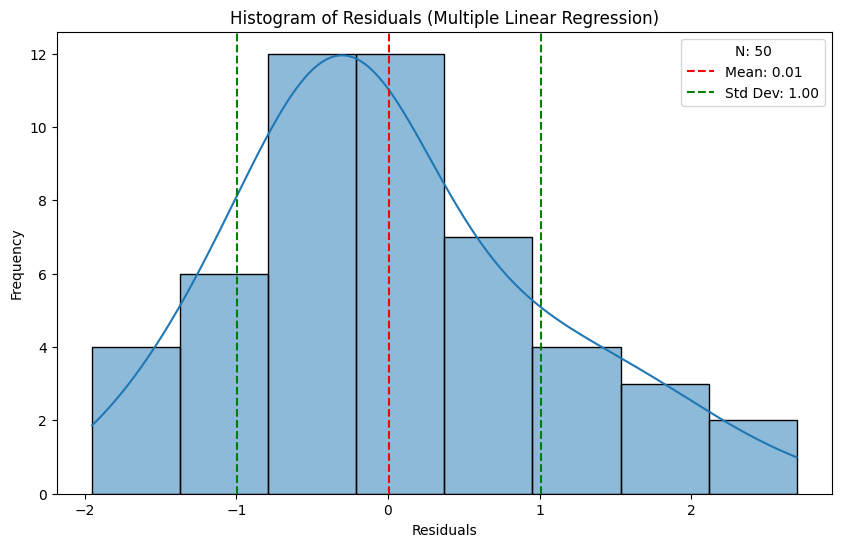

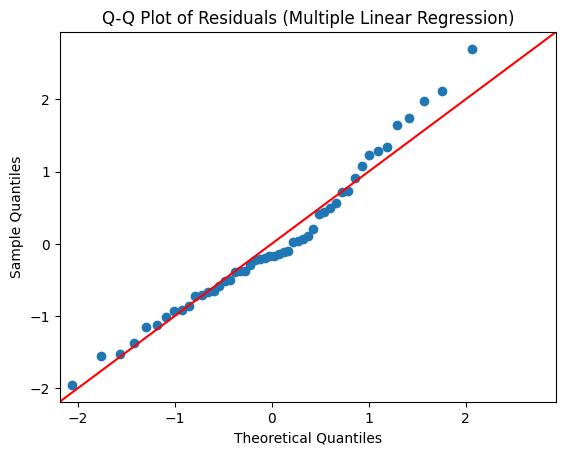

Read file multiple_linear_regression_results.xlsx


In [15]:
# Tạo mô hình hồi quy tuyến tính bội sử dụng công thức
# Create the formula for the regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the multiple linear regression model using the formula
model_multiple = smf.ols(formula, data=table).fit()
print(model_multiple.summary())

# Kiểm định Durbin-Watson
residuals_multiple = model_multiple.resid
durbin_watson_multiple = sm.stats.stattools.durbin_watson(residuals_multiple)

# Redesign the model_summary table
model_summary_multiple = pd.DataFrame({
  'Date': [model_multiple.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_multiple.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_multiple.rsquared],
  'Adj. R-squared': [model_multiple.rsquared_adj],
  'Durbin Watson': [durbin_watson_multiple]
})

# Bảng ANOVA
anova_table_multiple = sm.stats.anova_lm(model_multiple, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table[dependent_var] - table[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_multiple['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_multiple.summary().tables[0][6][1].data
df_residual = model_multiple.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_multiple.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_multiple.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_multiple = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_multiple['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})

# Bảng Coefficients
coefficients_multiple = model_multiple.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_multiple.params * (table[independent_vars].std() / table[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_multiple['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars
vif_data["VIF"] = [variance_inflation_factor(table[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_multiple dataframe
coefficients_multiple = coefficients_multiple.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
coefficients_multiple = coefficients_multiple[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]

# Đánh giá Adj. R-squared
adj_r_squared = model_multiple.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
# Kiểm định F - Kiểm tra Sig (p-value) bảng Anova
anova_p_value = anova_table_multiple.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_multiple < 2.5 else 'Autocorrelation present'
# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_multiple['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] < alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
non_significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] >= alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else: 
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
# Check for multicollinearity using VIF
multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
if not multicollinearity_vars.empty:
  multicollinearity_result = "There is a possibility of multicollinearity"
else:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria.':
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_multiple:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')

# Viết phương trình hồi quy
intercept = coefficients_multiple.loc[coefficients_multiple['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_multiple.loc[coefficients_multiple['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.2f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.2f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.2f} * {variable}'

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_multiple = model_multiple.get_influence().resid_studentized_internal
mean_residuals_multiple = standardized_residuals_multiple.mean()
std_dev_residuals_multiple = standardized_residuals_multiple.std()
N_residuals_multiple = len(standardized_residuals_multiple)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_multiple, kde=True)
plt.title('Histogram of Residuals (Multiple Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_multiple, color='r', linestyle='--', label=f'Mean: {mean_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple + std_dev_residuals_multiple, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple - std_dev_residuals_multiple, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_multiple}')
plt.savefig('histogram_of_residuals_multiple.png')
plt.show()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_multiple, line='45')
plt.title('Q-Q Plot of Residuals (Multiple Linear Regression)')
plt.savefig('qq_plot_of_residuals_multiple.png')
plt.show()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('multiple_linear_regression_results.xlsx') as writer:
  styled_corr_matrix.to_excel(writer, sheet_name='Corr Matrix')
  model_summary_multiple.to_excel(writer, sheet_name='Model Summary')
  anova_table_multiple.to_excel(writer, sheet_name='ANOVA')
  coefficients_multiple.to_excel(writer, sheet_name='Coefficients')
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  regression_equation_df.to_excel(writer, sheet_name='Regression Equation', index=False)
  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Residuals Plots')
  
  # Insert the images into the worksheet
  worksheet.insert_image('A1', 'histogram_of_residuals_multiple.png')
  worksheet.insert_image('A10', 'qq_plot_of_residuals_multiple.png')

print('Read file multiple_linear_regression_results.xlsx')

# 4.2.2 Optimize Model (if or not)

In [16]:
# Define the independent variables excluding 'dependent_var', 'may', and 'lit'
independent_vars = [var for var in table.columns if var not in [dependent_var, 'lit', 'may']] #input dependent remove
print(independent_vars)

['maluc', 'nang']


In [17]:
# Calculate the correlation matrix
correlation_matrix = table.corr()

# Save the correlation matrix to an Excel file
correlation_matrix.to_excel('multiple_linear_regression_correlation_coefficient_results_1.xlsx')

def highlight_cells(val):
  color = 'background-color: blue'
  if val >= 0.7 and val != 1:
    return color
  elif val <= -0.7:
    return color
  else:
    return ''

styled_corr_matrix = correlation_matrix.style.applymap(highlight_cells)

print('Read file multiple_linear_regression_correlation_coefficient_results_1.xlsx')
styled_corr_matrix

Read file multiple_linear_regression_correlation_coefficient_results_1.xlsx


/var/folders/90/0lwzz7y107b9zlcpf99xnks80000gn/T/ipykernel_84588/4209327565.py:16: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_matrix = correlation_matrix.style.applymap(highlight_cells)


,ttxang,maluc,nang,may,lit
ttxang,1.000000,-0.788177,-0.858138,-0.681132,-0.777281
maluc,-0.788177,1.000000,0.785739,0.751747,0.817545
nang,-0.858138,0.785739,1.000000,0.802332,0.900774
may,-0.681132,0.751747,0.802332,1.000000,0.941476
lit,-0.777281,0.817545,0.900774,0.941476,1.000000


                            OLS Regression Results                            
Dep. Variable:                 ttxang   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     78.81
Date:                Mon, 30 Dec 2024   Prob (F-statistic):           9.70e-16
Time:                        16:12:58   Log-Likelihood:                -97.649
No. Observations:                  50   AIC:                             201.3
Df Residuals:                      47   BIC:                             207.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.7783      1.109     23.235      0.0

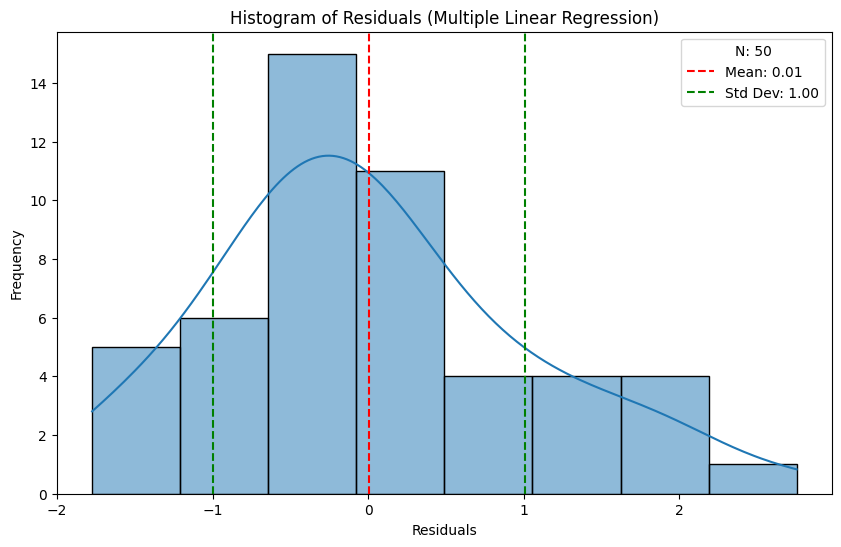

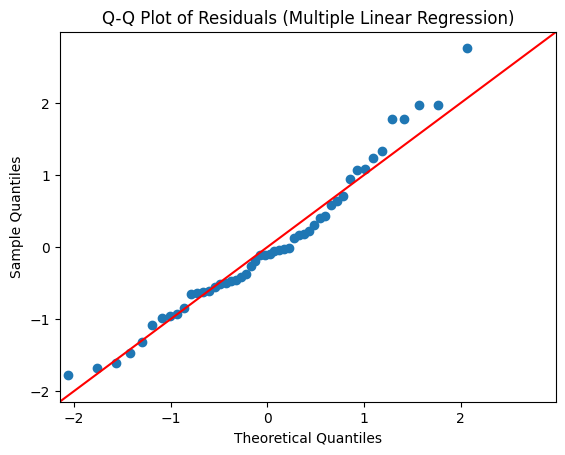

Read file multiple_linear_regression_results.xlsx


In [19]:
# Tạo mô hình hồi quy tuyến tính bội sử dụng công thức
# Create the formula for the regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the multiple linear regression model using the formula
model_multiple = smf.ols(formula, data=table).fit()
print(model_multiple.summary())

# Kiểm định Durbin-Watson
residuals_multiple = model_multiple.resid
durbin_watson_multiple = sm.stats.stattools.durbin_watson(residuals_multiple)

# Redesign the model_summary table
model_summary_multiple = pd.DataFrame({
  'Date': [model_multiple.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_multiple.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_multiple.rsquared],
  'Adj. R-squared': [model_multiple.rsquared_adj],
  'Durbin Watson': [durbin_watson_multiple]
})

# Bảng ANOVA
anova_table_multiple = sm.stats.anova_lm(model_multiple, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table[dependent_var] - table[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_multiple['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_multiple.summary().tables[0][6][1].data
df_residual = model_multiple.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_multiple.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_multiple.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_multiple = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_multiple['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})

# Bảng Coefficients
coefficients_multiple = model_multiple.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_multiple.params * (table[independent_vars].std() / table[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_multiple['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars
vif_data["VIF"] = [variance_inflation_factor(table[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_multiple dataframe
coefficients_multiple = coefficients_multiple.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
coefficients_multiple = coefficients_multiple[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]

# Đánh giá Adj. R-squared
adj_r_squared = model_multiple.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
# Kiểm định F - Kiểm tra Sig (p-value) bảng Anova
anova_p_value = anova_table_multiple.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_multiple < 2.5 else 'Autocorrelation present'
# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_multiple['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] < alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
non_significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] >= alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else: 
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
# Check for multicollinearity using VIF
multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
if not multicollinearity_vars.empty:
  multicollinearity_result = "There is a possibility of multicollinearity"
else:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria.':
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_multiple:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')

# Viết phương trình hồi quy
intercept = coefficients_multiple.loc[coefficients_multiple['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_multiple.loc[coefficients_multiple['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.2f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.2f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.2f} * {variable}'

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_multiple = model_multiple.get_influence().resid_studentized_internal
mean_residuals_multiple = standardized_residuals_multiple.mean()
std_dev_residuals_multiple = standardized_residuals_multiple.std()
N_residuals_multiple = len(standardized_residuals_multiple)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_multiple, kde=True)
plt.title('Histogram of Residuals (Multiple Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_multiple, color='r', linestyle='--', label=f'Mean: {mean_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple + std_dev_residuals_multiple, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple - std_dev_residuals_multiple, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_multiple}')
plt.savefig('histogram_of_residuals_multiple_1.png')
plt.show()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_multiple, line='45')
plt.title('Q-Q Plot of Residuals (Multiple Linear Regression)')
plt.savefig('qq_plot_of_residuals_multiple_1.png')
plt.show()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('multiple_linear_regression_results_1.xlsx') as writer:
  styled_corr_matrix.to_excel(writer, sheet_name='Corr Matrix')
  model_summary_multiple.to_excel(writer, sheet_name='Model Summary')
  anova_table_multiple.to_excel(writer, sheet_name='ANOVA')
  coefficients_multiple.to_excel(writer, sheet_name='Coefficients')
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  regression_equation_df.to_excel(writer, sheet_name='Regression Equation', index=False)
  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Residuals Plots')
  
  # Insert the images into the worksheet
  worksheet.insert_image('A1', 'histogram_of_residuals_multiple_1.png')
  worksheet.insert_image('A10', 'qq_plot_of_residuals_multiple_1.png')

print('Read file multiple_linear_regression_results.xlsx')